In [3]:
!pip install --quiet gdown
import gdown

file_id = "1XjTLTFlvxQPmepHbzPACfLPoMs0SKf46"
url = f"https://drive.google.com/uc?id={file_id}"
output_zip = "downloaded_file.zip"

print("Downloading...")
gdown.download(url, output_zip, quiet=False)

import zipfile
import os

extract_dir = "extracted_contents"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Done! '{extract_dir}'")


Downloading...


Downloading...
From (original): https://drive.google.com/uc?id=1XjTLTFlvxQPmepHbzPACfLPoMs0SKf46
From (redirected): https://drive.google.com/uc?id=1XjTLTFlvxQPmepHbzPACfLPoMs0SKf46&confirm=t&uuid=757acbe8-642b-45e7-8de4-defa6f9078f1
To: c:\dev\SmartPhoneGlobalSupplyChainChallenge\downloaded_file.zip
100%|██████████| 32.3M/32.3M [00:01<00:00, 24.8MB/s]


Done! 'extracted_contents'


In [24]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1) 데이터 로드 & 피벗
df = pd.read_csv("extracted_contents/data/consumer_confidence.csv", parse_dates=["month"])
wide = df.pivot(index="month", columns="country", values="confidence_index").sort_index()

# 2) 표준화 → PCA로 '글로벌 심리' 1~2개 요인 추출
scaler = StandardScaler()
Z = scaler.fit_transform(wide)              # shape: (T, 9)
pca = PCA(n_components=2).fit(Z)
global_factors = pca.transform(Z)           # 첫 PC = 공통 심리

# 3) Canada 후보 v1 : 첫 PC를 캐나다 스케일로 맞추기
#    (평균 100, 표준편차는 미국과 동일)
usa_mu, usa_sigma = wide["USA"].mean(), wide["USA"].std()
canada_v1 = global_factors[:, 0]            # 1차 요인
canada_v1 = (canada_v1 - canada_v1.mean()) / canada_v1.std()
canada_v1 = canada_v1 * usa_sigma + 100

# 4) Canada 후보 v2 : 교차검증 회귀
X = wide.drop(columns=["USA"])              # 예시: USA 예측용 실험
y = wide["USA"]
lags = 2                                     # t-1, t-2 추가
for lag in range(1, lags+1):
    X[f'PC1_lag{lag}'] = global_factors[:-lag, 0].tolist() + [None]*lag
X = X.dropna()
y = y.loc[X.index]

ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X, y)
print("RMSE(USA hold-out) :", np.sqrt(mean_squared_error(y, ridge.predict(X))))

# 캐나다는 열이 없으므로 결측으로 채우고 예측
full_X = wide.drop(columns=["USA"]).copy()
for lag in range(1, lags+1):
    full_X[f'PC1_lag{lag}'] = global_factors[:-lag, 0].tolist() + [None]*lag
canada_v2 = ridge.predict(full_X.dropna())

# 5) 최종 합치기 & 저장
canada_series = pd.Series(canada_v1, index=wide.index, name="CAN").round(5)

result_wide  = pd.concat([wide, canada_series], axis=1)
result_wide.columns.name = "country"

# 6) wide → long 형태로 되돌리기
result_long = (
    result_wide.round(5)          # 필요한 경우 반올림
               .stack()           # (month, country) → value
               .rename("confidence_index")
               .reset_index()     # 컬럼: ['month', 'country', 'confidence_index']
)

result_long["month"] = result_long["month"].dt.to_period("M").astype(str)
result_long.sort_values(["country", "month"], inplace=True)

# 7) 저장 (열 순서 그대로)
result_long.to_csv(
    "extracted_contents/data/consumer_confidence_with_canada_proxy.csv",
    index=False,
    columns=["month", "country", "confidence_index"]  # 열 순서 고정
)


RMSE(USA hold-out) : 0.04283822730514315


In [25]:
import pandas as pd
import numpy as np

def add_local_fx_iso(df: pd.DataFrame) -> pd.DataFrame:
    """
    country 컬럼(ISO 3자리 코드)에 따라 local_fx 컬럼에
    해당 국가 환율만 채워 줌.
    USA -> 1.0, 나머지는 매핑된 'XXX=X' 컬럼 값. 
    매핑 없으면 NaN.
    """
    # ISO 코드 → 환율 컬럼 매핑
    iso_to_fx = {
        'USA': 'USD',        # USD: 1.0
        'DEU': 'EUR=X',     # 유로존 (독일, 프랑스 등)
        'FRA': 'EUR=X',
        'KOR': 'KRW=X',
        'JPN': 'JPY=X',
        'GBR': 'GBP=X',
        'CAN': 'CAD=X',
        'AUS': 'AUD=X',
        'BRA': 'BRL=X',
        'ZAF': 'ZAR=X'
    }

    df = df.copy()
    def _pick_fx(row):
        fx_col = iso_to_fx.get(row['country'])

        if fx_col is None:
            raise ValueError(f"No FX column found for country: {row['country']}")
            
        if fx_col == 'USD':
            # USA 이거나 매핑이 없는 경우
            return 1.0
        # 환율 컬럼이 실제로 있으면 그 값, 없으면 NaN
        return row.get(fx_col, np.nan)

    df['local_fx'] = df.apply(_pick_fx, axis=1)
    return df


In [ ]:
import os
import gc
import pandas as pd
import sqlite3
import polars as pl
# ── 설정 ───────────────────────────────────────────────
DATA_DIR = 'extracted_contents/data'   # 실제 데이터 위치로 수정
OUT_DIR  = 'data'
os.makedirs(OUT_DIR, exist_ok=True)

# ── 1) 날짜·국가별 피처 전체 생성 (labour_policy 제외) ─────
cal  = pd.read_csv(os.path.join(DATA_DIR,'calendar.csv'),       parse_dates=['date'])
hol  = pd.read_csv(os.path.join(DATA_DIR,'holiday_lookup.csv'), parse_dates=['date'])
hol['is_holiday'] = 1

# --- weather: delta_humidity 보정 로직 추가
wth  = pd.read_csv(os.path.join(DATA_DIR,'weather.csv'),        parse_dates=['date'])
# country, date 순으로 정렬 후 humidity 차분으로 delta_humidity 계산
wth = wth.sort_values(['country','date'])
wth['delta_humidity'] = wth.groupby('country')['humidity'].diff()
# 2018-01-01은 0으로 고정
wth.loc[wth['date'] == pd.Timestamp('2018-01-01'), 'delta_humidity'] = 0

# --- oil_price: 주말은 마지막 영업일 기준으로 forward-fill
oil  = pd.read_csv(os.path.join(DATA_DIR,'oil_price.csv'),      parse_dates=['date'])
oil = (
    oil
    .set_index('date')
    .resample('D')     # 모든 날짜로 확장
    .ffill()           # 직전 값으로 채우기
    .reset_index()
)

# --- currency: 마찬가지로 주말은 마지막 영업일 값으로 채우기
cur  = pd.read_csv(os.path.join(DATA_DIR,'currency.csv'),       parse_dates=['Date'])
cur = (
    cur
    .rename(columns={'Date':'date'})
    .set_index('date')
    .resample('D')
    .ffill()
    .reset_index()
)


cons = pd.read_csv(os.path.join(DATA_DIR,'consumer_confidence_with_canada_proxy.csv'),
                   parse_dates=['month'])
cons['month'] = cons['month'].dt.to_period('M')


df = (
    cal
    .merge(hol[['date','country','is_holiday']], on=['date','country'], how='left')
    .fillna({'is_holiday':0})
    .merge(wth, on=['date','country'], how='left')
    .merge(oil, on='date', how='left')
    .merge(cur, left_on='date', right_on='date', how='left')
    .assign(month=lambda d: d['date'].dt.to_period('M'))
    .merge(cons[['month','country','confidence_index']],
           on=['month','country'], how='left')
    .drop(columns=['month'])
)
df.rename(columns={'confidence_index':'CAN=X'}, inplace=True)
date_feat = df.copy()
del df, cal, hol, wth, oil, cur, cons
gc.collect()

# ── 2) SKU 메타 추출 ─────────────────────────────────
sku_meta = pd.read_csv(os.path.join(DATA_DIR,'sku_meta.csv'),
                       parse_dates=['launch_date'])
sku_meta['launch_date'] = pd.to_datetime(sku_meta['launch_date'])
needed_sku = ['family','storage_gb','colour','life_days','launch_date']
sku_map = sku_meta.set_index('sku')[needed_sku].to_dict()
del sku_meta
gc.collect()

# ── 3) price_promo_train 로드 & imputation 자료 생성 ────
ppt = pd.read_csv(os.path.join(DATA_DIR,'price_promo_train.csv'),
                  parse_dates=['date'])
# 3-1) Base price: 2022년 평균
base_price = (ppt[ppt['date'].dt.year == 2022]
              .groupby(['sku','city'])['unit_price']
              .mean())
base_discount = (ppt[ppt['date'].dt.year == 2022]
                 .groupby(['sku','city'])['discount_pct']
                 .mean())
base_price_map = base_price.to_dict()
base_discount_map = base_discount.to_dict()

# 3-2) Last-month forecast-forward
last_date = ppt['date'].max()
last_data = ppt[ppt['date'] == last_date][['sku','city','unit_price','discount_pct']]
last_price_map = dict(zip(zip(last_data['sku'], last_data['city']), last_data['unit_price']))
last_discount_map = dict(zip(zip(last_data['sku'], last_data['city']), last_data['discount_pct']))

# 3-3) Monthly average by month-of-year
ppt['month'] = ppt['date'].dt.month
monthly_avg = (ppt.groupby(['sku','city','month'])
               [['unit_price','discount_pct']]
               .mean()
               .rename(columns={'unit_price':'unit_price_month',
                                'discount_pct':'discount_pct_month'}))
monthly_price_map = monthly_avg['unit_price_month'].to_dict()
monthly_discount_map = monthly_avg['discount_pct_month'].to_dict()
del ppt, base_price, base_discount, last_data, monthly_avg
gc.collect()

# ── 4) 학습용 데이터셋 생성 (2018–2022) ─────────────────
conn = sqlite3.connect(os.path.join(DATA_DIR,'demand_train.db'))
demand = pd.read_sql('SELECT * FROM demand_train', conn, parse_dates=['date'])
site_cand = pd.read_csv(os.path.join(DATA_DIR,'site_candidates.csv'))
city_country = site_cand[['city','country']].drop_duplicates()
demand = demand.merge(city_country, on='city', how='left')

marketing = pd.read_csv(os.path.join(DATA_DIR,'marketing_spend.csv'),
                        parse_dates=['date'])

train = (
    demand
    .merge(date_feat,   on=['date','country'],    how='left')
    .merge(marketing,   on=['date','country'],    how='left')
)
del demand
gc.collect()

for col in needed_sku:
    train[col] = train['sku'].map(sku_map[col])

# price_promo_train은 레이블 학습용으로만 사용
train = train.merge(
    pd.read_csv(os.path.join(DATA_DIR,'price_promo_train.csv'),
                parse_dates=['date']),
    on=['date','sku','city'], how='left'
)
train.drop(columns=["unit_price"], inplace=True)
ppt_full = pd.read_csv(os.path.join(DATA_DIR,'price_promo_train.csv'),
                       parse_dates=['date'])
# discount_pct == 0.0 인 원가격만 추출해 sku, city 별 평균 계산
orig_price_map = (
    ppt_full[ppt_full['discount_pct'] == 0.0]
    .groupby(['sku','city'])['unit_price']
    .mean()
    .to_dict()
)
train['unit_price'] = train.apply(
    lambda r: orig_price_map.get((r['sku'], r['city'])),
    axis=1
)


FX = ["CAD=X","AUD=X","BRL=X","ZAR=X","EUR=X","KRW=X","JPY=X","GBP=X","CAN=X"]
# ONEHOT_COLS = ["season","category","colour"]
# LABEL_COLS  = ["country","family"]
# DELETE_COLS = ['season_nan', 'category_nan', 'colour_nan']

# 1) 환율 forward-fill (벡터화)
train[FX] = train.groupby(["sku","city"])[FX].ffill()

# 2) days_since_launch
train["days_since_launch"] = (
    (train["date"] - train["launch_date"]).dt.days
).astype("float32")

train = train.drop(columns=["launch_date"])
train = add_local_fx_iso(train)
train = train.drop(columns=FX)
# 4) 인코딩
# train = pd.get_dummies(train, columns=ONEHOT_COLS, dummy_na=True, dtype="float32")
# train = train.drop(columns=DELETE_COLS)

# for col in LABEL_COLS:
#     train[col] = train[col].astype("category").cat.codes.astype("float32")


# train.to_csv(os.path.join(OUT_DIR,'train_master.csv'), index=False)
pl.from_pandas(train).write_csv(os.path.join(OUT_DIR,'train_master.csv'))
print("Saved train_master.csv")
gc.collect()

# ── 5) 예측용 데이터셋 생성 (2023–2024) ────────────────
forecast = pd.read_csv(os.path.join(DATA_DIR,'forecast_submission_template.csv'),
                       parse_dates=['date'])
forecast = forecast.merge(city_country, on='city', how='left')
test = (
    forecast
    .merge(date_feat, on=['date','country'], how='left')
    .merge(marketing, on=['date','country'], how='left')
)
del forecast, marketing
gc.collect()

# 필요한 SKU 피처 attach
for col in needed_sku:
    test[col] = test['sku'].map(sku_map[col])

# ── 5-1) original_price 추가: discount_pct == 0.0 인 시점의 unit_price 매핑 ──
ppt_full = pd.read_csv(os.path.join(DATA_DIR,'price_promo_train.csv'),
                       parse_dates=['date'])
# discount_pct == 0.0 인 원가격만 추출해 sku, city 별 평균 계산
orig_price_map = (
    ppt_full[ppt_full['discount_pct'] == 0.0]
    .groupby(['sku','city'])['unit_price']
    .mean()
    .to_dict()
)
# test 에 unit_price 컬럼 추가 할인율 반영 x
test['unit_price'] = test.apply(
    lambda r: orig_price_map.get((r['sku'], r['city'])),
    axis=1
)
del ppt_full, orig_price_map
gc.collect()

# 1) 환율 forward-fill (벡터화)
test[FX] = test.groupby(["sku","city"])[FX].ffill()
test = add_local_fx_iso(test)
test = test.drop(columns=FX)

# 2) days_since_launch
test["days_since_launch"] = (
    (test["date"] - test["launch_date"]).dt.days
).astype("float32")
test = test.drop(columns=["launch_date"])
# 4) 인코딩
# test = pd.get_dummies(test, columns=ONEHOT_COLS, dummy_na=True, dtype="float32")
# for col in LABEL_COLS:
#     test[col] = test[col].astype("category").cat.codes.astype("float32")
# test = test.drop(columns=DELETE_COLS)

# test.to_csv(os.path.join(OUT_DIR,'test_master.csv'), index=False)
pl.from_pandas(test).write_csv(os.path.join(OUT_DIR,'test_master.csv'))
print("Saved test_master.csv")

pl.from_pandas(pd.concat([train, test])).write_csv(os.path.join(OUT_DIR,'all_master.csv'))
print("Saved all_master.csv")









Saved train_master.csv
Saved test_master.csv


In [10]:
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

# 로컬 IQR 클리핑 함수 (기존과 동일)
def local_iqr_clip(series, window=30, q1=0.25, q3=0.75, m=1.5):
    roll_q1 = series.rolling(window, center=True).quantile(q1)
    roll_q3 = series.rolling(window, center=True).quantile(q3)
    iqr     = roll_q3 - roll_q1
    upper   = roll_q3 + m * iqr
    return series.clip(0, upper)

# 한 그룹(sku, city)에 대한 처리 함수
def process_group(item):
    (sku, city), subdf = item
    clipped = local_iqr_clip(subdf['demand'], window=30, m=3.0)
    pct     = (clipped != subdf['demand']).mean() * 100
    return {'sku': sku, 'city': city, 'pct': pct}

# 1) 데이터 로드
df = pd.read_csv('demand_train.csv', parse_dates=['date'])

# 2) 그룹 리스트로 변환
groups = list(df.groupby(['sku', 'city']))

# 3) 병렬 실행
results = Parallel(n_jobs=-1)(
    delayed(process_group)(grp)
    for grp in tqdm(groups, desc='Processing groups')
)

# 4) 결과 집계
pct_df = pd.DataFrame(results)
print(pct_df.describe())


Processing groups: 100%|██████████| 1000/1000 [00:00<00:00, 4439.08it/s]

               pct
count  1000.000000
mean      0.682366
std       0.264812
min       0.109529
25%       0.492881
50%       0.657174
75%       0.821468
max       1.752464


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
dataset = pd.read_csv("data/train_master.csv", parse_dates=['date'])

country_list = dataset['country'].unique()


os.makedirs("country_demand", exist_ok=True)
for country in tqdm(country_list):

    df = dataset[(dataset['country'] == country)]

    # 국가-일자별 도시 수(커버리지), 총 도시 수 대비 비율
    total_city_cnt = df.groupby('country')['city'].nunique().rename('total_cities')
    daily_city_cnt = df.groupby(['country','date'])['city'].nunique().rename('active_cities')

    df = df.merge(total_city_cnt, on='country')
    df = df.merge(daily_city_cnt, on=['country','date'])
    df['city_coverage'] = df['active_cities'] / df['total_cities']

    # 국가-일자 총 수요
    df['country_demand'] = df.groupby(['country','date'])['demand'].transform('sum')

    # (선택) 기준선 대비 증감율: 최근 28일 이동평균 등
    df['baseline'] = (df.groupby('country')['country_demand']
                        .transform(lambda s: s.rolling(28, min_periods=7).mean()))
    df['lift_pct'] = (df['country_demand'] - df['baseline']) / df['baseline']

    fig, ax = plt.subplots()
    for c, g in df.groupby('country'):
        g = g.sort_values('date')
        ax.plot(g['date'], g['country_demand'], label=c)
        ax.fill_between(g['date'], 0, g['city_coverage']*g['country_demand'].max()*0.1,
                        alpha=0.2)  # 커버리지를 보조로
    ax.legend()
    plt.savefig(f"country_demand/country_{country}.png")
    plt.close()

# df_z = (df
#         .assign(z = df.groupby(['city'])['demand']
#                        .transform(lambda x: (x-x.mean())/x.std()))
#         .pivot_table(index='city', columns='date', values='z'))
# sns.heatmap(df_z, center=0)

100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os

dataset = pd.read_csv("forecast_submission_template.csv", parse_dates=['date'])
country_df = pd.read_csv("extracted_contents/data/site_candidates.csv")

dataset = dataset.merge(
    country_df[['city', 'country']],
    on='city',
    how='left'        # city가 없으면 NaN으로 남깁니다. 필요에 따라 'inner'로 변경 가능
)

country_list = dataset['country'].unique()

dir_name = "demand_plot"
os.makedirs(dir_name, exist_ok=True)

for country in tqdm(country_list):
    df = dataset[dataset['country'] == country].copy()

    # 국가-일자별 도시 수(커버리지), 총 도시 수 대비 비율
    total_city_cnt = df.groupby('country')['city'].nunique().rename('total_cities')
    daily_city_cnt = df.groupby(['country', 'date'])['city'].nunique().rename('active_cities')

    df = df.merge(total_city_cnt, on='country')
    df = df.merge(daily_city_cnt, on=['country', 'date'])
    df['city_coverage'] = df['active_cities'] / df['total_cities']

    # 국가-일자 총 수요
    df['country_demand'] = df.groupby(['country', 'date'])['mean'].transform('sum')

    # 기준선 대비 증감율(선택)
    df['baseline'] = (df.groupby('country')['country_demand']
                        .transform(lambda s: s.rolling(28, min_periods=7).mean()))
    df['lift_pct'] = (df['country_demand'] - df['baseline']) / df['baseline']

    # 정렬
    g = df.sort_values('date')

    # 플롯
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(g['date'], g['country_demand'], label=country)
    ax.fill_between(g['date'],
                    0,
                    g['city_coverage'] * g['country_demand'].max() * 0.1,
                    alpha=0.2,
                    step='mid')

    ax.set_ylabel('Demand')
    ax.legend(loc='upper left')

    # ---- 여기서 월 라벨 세팅 ----
    ax.xaxis.set_major_locator(mdates.MonthLocator())               # 주요 tick: 매월
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))     # 라벨 형식
    fig.autofmt_xdate()                                             # 라벨 자동 회전

    plt.tight_layout()
    plt.savefig(f"{dir_name}/country_{country}.png", dpi=150)
    plt.close()

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


이벤트 스파이크 후처리 작업을 시작합니다...

2023년 BRA 이벤트 처리 중...
 -> 경고: 'BRA'에 대한 blueprint가 없습니다. 기본값 'KOR'을(를) 사용합니다.
 -> '2022년 KOR' 데이터를 청사진으로 사용합니다.
 -> 100개의 그룹에 대한 베이스라인 수요를 계산했습니다.


C:\Users\tjqtj\AppData\Local\Temp\ipykernel_13888\3734398601.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[209.40165975 209.40165975 219.51070539 ... 313.28571429 307.57142857
 307.57142857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.loc[apply_mask, 'demand'] = df_result.loc[apply_mask, 'baseline'] * df_result.loc[apply_mask, 'multiplier']


 -> 성공적으로 수요를 수정했습니다.

2024년 DEU 이벤트 처리 중...
 -> 경고: 'DEU'에 대한 blueprint가 없습니다. 기본값 'KOR'을(를) 사용합니다.
 -> '2022년 KOR' 데이터를 청사진으로 사용합니다.
 -> 100개의 그룹에 대한 베이스라인 수요를 계산했습니다.
 -> 성공적으로 수요를 수정했습니다.

후처리 작업 완료!


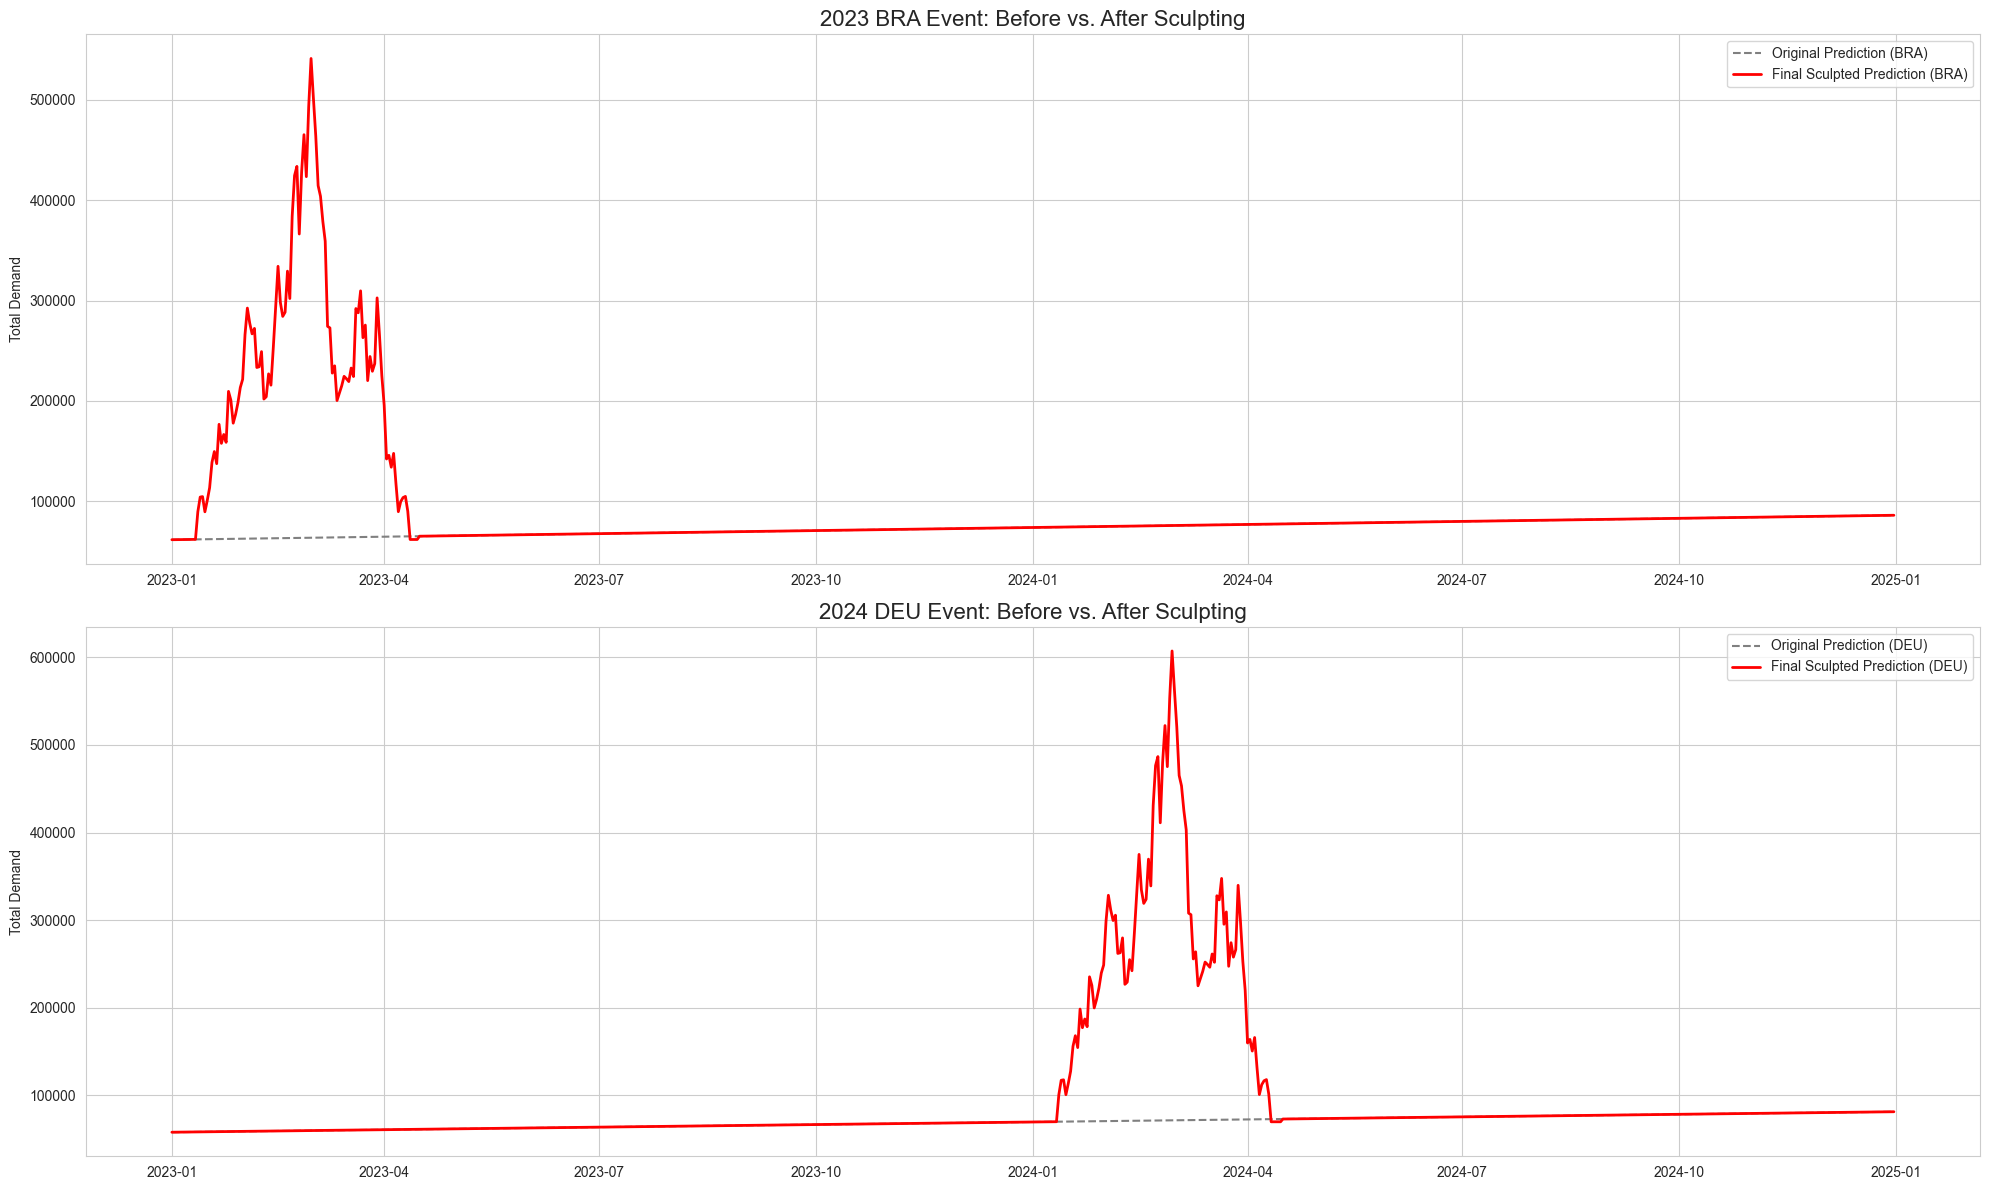

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- 1. 설정: 이벤트 청사진 및 미래 이벤트 기간 정의 ---

# 과거의 어떤 이벤트를 '청사진(Blueprint)'으로 사용할지 정의
event_blueprints = {
    "KOR": {"year": 2022, "start_date": "2022-01-23", "end_date": "2022-04-22"},
    # "KOR": {"year": 2022, "start_date": "2022-02-15", "end_date": "2022-04-05"},
    "JPN": {"year": 2019, "start_date": "2019-01-25", "end_date": "2019-02-25"},
    "USA": {"year": 2021, "start_date": "2021-04-01", "end_date": "2021-06-08"} # 다른 국가를 위한 청사진 추가
}
# 새로운 국가에 대한 이벤트 예측 시, 어떤 청사진을 기본값으로 사용할지 정의
DEFAULT_BLUEPRINT_COUNTRY = "KOR"  

# 사용자가 제공한, 이벤트를 그려 넣을 미래 기간 정의
# future_event_periods = {
#     2023: {"country": "AUS", "start_date": "2023-07-25", "end_date": "2023-08-13"},
#     2024: {"country": "DEU", "start_date": "2024-02-13", "end_date": "2024-04-15"}
# }
# future_event_periods = {
#     2023: {"country": "AUS", "start_date": "2023-04-06", "end_date": "2023-06-11"},
#     2024: {"country": "DEU", "start_date": "2024-01-12", "end_date": "2024-04-15"}
# }
future_event_periods = {
    # 2023: {"country": "AUS", "start_date": "2023-04-06", "end_date": "2023-06-11"},
    2023: {"country": "BRA", "start_date": "2023-01-12", "end_date": "2023-04-15"}, # ['BRA' 'ZAF' 'FRA']
    2024: {"country": "DEU", "start_date": "2024-01-12", "end_date": "2024-04-15"}
}
# --- 2. 함수 정의 (수정 및 개선됨) ---
# --- 2. 함수 정의 (수정됨) ---
def create_event_profile(historical_df: pd.DataFrame, country: str, start_date: str, end_date: str) -> np.ndarray:
    country_agg = historical_df[historical_df['country'] == country].groupby('date')['demand'].sum().reset_index()
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    baseline_start, baseline_end = start_date - pd.Timedelta(days=7), start_date - pd.Timedelta(days=1)
    
    baseline_mask = (country_agg['date'] >= baseline_start) & (country_agg['date'] <= baseline_end)
    baseline_demand = country_agg.loc[baseline_mask, 'demand'].mean()
    
    if pd.isna(baseline_demand) or baseline_demand < 1:
        return np.array([1.0])

    event_mask = (country_agg['date'] >= start_date) & (country_agg['date'] <= end_date)
    event_demands = country_agg.loc[event_mask, 'demand']
    
    return (event_demands / baseline_demand).values

def sculpt_events_on_prediction(
    predicted_df: pd.DataFrame,
    historical_df: pd.DataFrame,
    future_event_periods: dict,
    event_blueprints: dict
) -> pd.DataFrame:
    df_result = predicted_df.copy()
    df_result['group_id'] = df_result['sku'] + "_" + df_result['city']

    print("이벤트 스파이크 후처리 작업을 시작합니다...")

    for year, future_event in future_event_periods.items():
        country_to_sculpt = future_event['country']
        future_start = pd.to_datetime(future_event['start_date'])
        future_end = pd.to_datetime(future_event['end_date'])
        
        print(f"\n{year}년 {country_to_sculpt} 이벤트 처리 중...")

        # 1. 사용할 이벤트 프로파일 결정 (Fallback 로직 추가)
        blueprint_country = country_to_sculpt
        if country_to_sculpt not in event_blueprints:
            print(f" -> 경고: '{country_to_sculpt}'에 대한 blueprint가 없습니다. 기본값 '{DEFAULT_BLUEPRINT_COUNTRY}'을(를) 사용합니다.")
            blueprint_country = DEFAULT_BLUEPRINT_COUNTRY
        
        blueprint_info = event_blueprints[blueprint_country]
        
        # <<< --- 에러 수정 지점 --- >>>
        # blueprint_info['country'] 대신, blueprint를 가져오기 위해 사용한 'blueprint_country' 변수를 사용합니다.
        print(f" -> '{blueprint_info['year']}년 {blueprint_country}' 데이터를 청사진으로 사용합니다.")
        profile = create_event_profile(
            historical_df, 
            blueprint_country, # <-- 여기도 수정
            blueprint_info['start_date'], 
            blueprint_info['end_date']
        )
        
        if len(profile) <= 1 and np.all(profile == 1.0):
            print(f" -> 경고: {country_to_sculpt}의 프로파일을 생성할 수 없습니다. 이벤트를 건너뜁니다.")
            continue
        
        baseline_start = future_start - pd.Timedelta(days=7)
        baseline_end = future_start - pd.Timedelta(days=1)
        baseline_mask = (df_result['country'] == country_to_sculpt) & (df_result['date'] >= baseline_start) & (df_result['date'] <= baseline_end)
        group_baselines = df_result[baseline_mask].groupby('group_id')['demand'].mean()
        print(f" -> {len(group_baselines)}개의 그룹에 대한 베이스라인 수요를 계산했습니다.")

        event_mask = (df_result['country'] == country_to_sculpt) & (df_result['date'] >= future_start) & (df_result['date'] <= future_end)
        
        df_result.loc[event_mask, 'days_since_event_start'] = (df_result.loc[event_mask, 'date'] - future_start).dt.days
        profile_map = {i: multiplier for i, multiplier in enumerate(profile)}
        
        df_result['multiplier'] = 1.0
        df_result.loc[event_mask, 'multiplier'] = df_result.loc[event_mask, 'days_since_event_start'].map(profile_map).fillna(1.0)
        
        df_result['baseline'] = df_result['group_id'].map(group_baselines)
        
        apply_mask = event_mask & (df_result['baseline'].notna())
        df_result.loc[apply_mask, 'demand'] = df_result.loc[apply_mask, 'baseline'] * df_result.loc[apply_mask, 'multiplier']
        
        print(f" -> 성공적으로 수요를 수정했습니다.")

    df_result = df_result.drop(columns=['group_id', 'days_since_event_start', 'multiplier', 'baseline'], errors='ignore')
    print("\n후처리 작업 완료!")
    return df_result


# --- 3. 실행 ---
historical_df = pd.read_csv('data/train_master.csv', parse_dates=['date']) # 과거 실제 데이터
country_df = pd.read_csv('extracted_contents/data/site_candidates.csv')
predicted_df = pd.read_csv('LinearRegression/forecast_submission_template.csv', parse_dates=['date'])   # 모델의 예측 결과

predicted_df = predicted_df.merge(country_df[['city', 'country']], on='city', how='left')
historical_df.rename(columns={'demand': 'mean'}, inplace=True)

# 이벤트 조각하기 함수 실행 (컬럼명을 'demand'로 통일하여 전달)
final_prediction_df = sculpt_events_on_prediction(
    predicted_df=predicted_df.rename(columns={'mean': 'demand'}),
    historical_df=historical_df.rename(columns={'mean': 'demand'}),
    future_event_periods=future_event_periods,
    event_blueprints=event_blueprints
).rename(columns={'demand': 'mean'}) # 최종 결과를 다시 'mean'으로

# --- 4. 시각화로 결과 확인 (동적으로 생성) ---
sns.set_style("whitegrid")
num_events = len(future_event_periods)
fig, axes = plt.subplots(num_events, 1, figsize=(20, 6 * num_events), squeeze=False)

for i, (year, event_info) in enumerate(future_event_periods.items()):
    country = event_info['country']
    ax = axes[i, 0]
    
    # 국가별로 집계하여 시각화
    original_agg = predicted_df[predicted_df['country'] == country].groupby('date')['mean'].sum()
    final_agg = final_prediction_df[final_prediction_df['country'] == country].groupby('date')['mean'].sum()
    
    ax.plot(original_agg.index, original_agg.values, label=f'Original Prediction ({country})', color='grey', linestyle='--')
    ax.plot(final_agg.index, final_agg.values, label=f'Final Sculpted Prediction ({country})', color='red', linewidth=2)
    ax.set_title(f'{year} {country} Event: Before vs. After Sculpting', fontsize=16)
    ax.set_ylabel('Total Demand')
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
if 'country' in final_prediction_df.columns:
    final_prediction_df.drop(columns=['country'], inplace=True)
final_prediction_df['mean'] = final_prediction_df['mean'].astype(int)
sub = pd.read_csv("extracted_contents/data/forecast_submission_template.csv", parse_dates=["date"])
final_prediction_df = final_prediction_df.loc[final_prediction_df['date'] >= '2023-01-01']
final_prediction_df = final_prediction_df.drop_duplicates() 
sub.drop(columns=['mean'], inplace=True)
sub = sub.merge(final_prediction_df, on=['sku', 'city', 'date'], how='left')
sub.to_csv("result.csv", index=False)
sub.to_csv("forecast_submission_template.csv", index=False)

In [50]:
pre = pd.read_csv('forecast_submission_template.csv', parse_dates=['date']).drop_duplicates() 
pre.to_csv('forecast_submission_template.csv', index=False)

In [51]:
country_df = pd.read_csv('extracted_contents/data/site_candidates.csv')
print(country_df['country'].unique())

['USA' 'DEU' 'FRA' 'KOR' 'JPN' 'GBR' 'CAN' 'AUS' 'BRA' 'ZAF']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os

dataset = pd.read_csv("demand_train.csv", parse_dates=['date'])
country_df = pd.read_csv("extracted_contents/data/site_candidates.csv")

dataset = dataset.merge(
    country_df[['city', 'country']],
    on='city',
    how='left'        # city가 없으면 NaN으로 남깁니다. 필요에 따라 'inner'로 변경 가능
)

country_list = dataset['country'].unique()

os.makedirs("country_demand", exist_ok=True)

for country in tqdm(country_list):
    df = dataset[dataset['country'] == country].copy()

    # 국가-일자별 도시 수(커버리지), 총 도시 수 대비 비율
    total_city_cnt = df.groupby('country')['city'].nunique().rename('total_cities')
    daily_city_cnt = df.groupby(['country', 'date'])['city'].nunique().rename('active_cities')

    df = df.merge(total_city_cnt, on='country')
    df = df.merge(daily_city_cnt, on=['country', 'date'])
    df['city_coverage'] = df['active_cities'] / df['total_cities']

    # 국가-일자 총 수요
    df['country_demand'] = df.groupby(['country', 'date'])['demand'].transform('sum')

    # 기준선 대비 증감율(선택)
    df['baseline'] = (df.groupby('country')['country_demand']
                        .transform(lambda s: s.rolling(28, min_periods=7).mean()))
    df['lift_pct'] = (df['country_demand'] - df['baseline']) / df['baseline']

    # 정렬
    g = df.sort_values('date')

    # 플롯
    fig, ax = plt.subplots(figsize=(200, 12))
    ax.plot(g['date'], g['country_demand'], label=country)
    ax.fill_between(g['date'],
                    0,
                    g['city_coverage'] * g['country_demand'].max() * 0.1,
                    alpha=0.2,
                    step='mid')

    ax.set_ylabel('Demand')
    ax.legend(loc='upper left')

    # ---- 여기서 월 라벨 세팅 ----
    # ax.xaxis.set_major_locator(mdates.MonthLocator())               # 주요 tick: 매월
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))     # 라벨 형식
    # fig.autofmt_xdate()             
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # 7일 간격으로 주요 tick 표시
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 라벨 형식: 연-월-일
    fig.autofmt_xdate()  # 라벨 자동 회전

    plt.tight_layout()
    plt.savefig(f"country_demand/country_{country}.png", dpi=150)
    plt.close()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os

dataset = pd.read_csv("forecast_submission_template.csv", parse_dates=['date'])
country_df = pd.read_csv("extracted_contents/data/site_candidates.csv")

dataset = dataset.merge(
    country_df[['city', 'country']],
    on='city',
    how='left'        # city가 없으면 NaN으로 남깁니다. 필요에 따라 'inner'로 변경 가능
)

city_list = dataset['city'].unique()

os.makedirs("city_demand", exist_ok=True)

for city in tqdm(city_list):
    df = dataset[dataset['city'] == city].copy()
    # 정렬
    g = df.sort_values('date')

    # 플롯
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(g['date'], g['mean'], label=city)
    ax.set_ylabel('Demand')
    ax.legend(loc='upper left')

    # ---- 여기서 월 라벨 세팅 ----
    ax.xaxis.set_major_locator(mdates.MonthLocator())               # 주요 tick: 매월
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))     # 라벨 형식
    fig.autofmt_xdate()                                             # 라벨 자동 회전

    plt.tight_layout()
    plt.savefig(f"city_demand/city_{city}.png", dpi=150)
    plt.close()

100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os


dataset = pd.read_csv("data/train_master.csv", parse_dates=['date'])

# 같은 날짜, 같은 나라 기준으로 demand 합산
aggregated_df = dataset.groupby(['date', 'country'], as_index=False)['demand'].sum()
aggregated_df.to_csv("aggregated_df.csv", index=False)

# 결과 확인
print(aggregated_df.head())

        date country  demand
0 2018-01-01     AUS    5018
1 2018-01-01     BRA    4826
2 2018-01-01     CAN    3571
3 2018-01-01     DEU    3845
4 2018-01-01     FRA    4196


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os


dataset = pd.read_csv("forecast_submission_template.csv", parse_dates=['date'])
country_df = pd.read_csv("extracted_contents/data/site_candidates.csv")

dataset = dataset.merge(
    country_df[['city', 'country']],
    on='city',
    how='left'        # city가 없으면 NaN으로 남깁니다. 필요에 따라 'inner'로 변경 가능
)

# 같은 날짜, 같은 나라 기준으로 demand 합산
aggregated_df = dataset.groupby(['date', 'country'], as_index=False)['mean'].sum()

# 결과 확인
print(aggregated_df.head())
aggregated_df.to_csv("submission_aggregated_df.csv", index=False)

        date country   mean
0 2023-01-01     AUS  75230
1 2023-01-01     BRA  62360
2 2023-01-01     CAN  60824
3 2023-01-01     DEU  72114
4 2023-01-01     FRA  68692


In [5]:
aggregated_df.to_csv("aggregated_df.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   # ← 추가
from tqdm import tqdm
import os


dataset = pd.read_csv("data/train_master.csv", parse_dates=['date'])

country_list = dataset['country'].unique()
numberic_cols = dataset.select_dtypes(include=['number']).columns

output_dir = "outputs/plots"
os.makedirs(output_dir, exist_ok=True)


for col in tqdm(numberic_cols):
    col_dir = f"{output_dir}/{col}"
    os.makedirs(col_dir, exist_ok=True)

    for country in country_list:


        df = dataset[dataset['country'] == country].copy()

        # 국가-일자별 도시 수(커버리지), 총 도시 수 대비 비율
        total_city_cnt = df.groupby('country')['city'].nunique().rename('total_cities')
        daily_city_cnt = df.groupby(['country', 'date'])['city'].nunique().rename('active_cities')

        df = df.merge(total_city_cnt, on='country')
        df = df.merge(daily_city_cnt, on=['country', 'date'])
        df['city_coverage'] = df['active_cities'] / df['total_cities']

        # 국가-일자 총 수요
        df[f'country_{col}'] = df.groupby(['country', 'date'])[col].transform('sum')

        # 기준선 대비 증감율(선택)
        df['baseline'] = (df.groupby('country')[f'country_{col}']
                            .transform(lambda s: s.rolling(28, min_periods=7).mean()))
        df['lift_pct'] = (df[f'country_{col}'] - df['baseline']) / df['baseline']

        # 정렬
        g = df.sort_values('date')

        # 플롯
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.plot(g['date'], g[f'country_{col}'], label=country)
        ax.fill_between(g['date'],
                        0,
                        g['city_coverage'] * g[f'country_{col}'].max() * 0.1,
                        alpha=0.2,
                        step='mid')

        ax.set_ylabel(col)
        ax.legend(loc='upper left')

        # ---- 여기서 월 라벨 세팅 ----
        ax.xaxis.set_major_locator(mdates.MonthLocator())               # 주요 tick: 매월
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))     # 라벨 형식
        fig.autofmt_xdate()                                             # 라벨 자동 회전

        plt.tight_layout()
        plt.savefig(f"{col_dir}/country_{country}.png", dpi=150)
        plt.close()

100%|██████████| 31/31 [03:11<00:00,  6.16s/it]


In [ ]:
['BRA' 'ZAF' 'FRA']


In [6]:
import pandas as pd
import numpy as np

# ───────── 파라미터 ─────────
WINDOW    = 30        # 롤링 윈도우(일)
Z_THR     = 5         # robust z-score 임계값
LIFT_THR  = 2.5       # baseline 대비 배수 임계값
MIN_LEN   = 60         # 최소 연속 일수
GROUP_COLS = ["country"]   # 필요시 ["country","sku"] 등으로 변경

# ───────── 데이터 로드 ─────────
df = pd.read_csv("data/train_master.csv", parse_dates=["date"])
df = df.sort_values(GROUP_COLS + ["date"]).reset_index(drop=True)

# ───────── 기준선(중앙값) & MAD 계산 ─────────
def add_robust_stats(g):
    med = g["demand"].rolling(WINDOW, center=True, min_periods=WINDOW//2).median()
    mad = (g["demand"] - med).abs().rolling(WINDOW, center=True, min_periods=WINDOW//2).median()
    z   = (g["demand"] - med) / (1.4826 * mad + 1e-6)
    lift = g["demand"] / (med + 1e-6)
    g["roll_med"] = med
    g["roll_mad"] = mad
    g["zscore"]   = z
    g["lift"]     = lift
    g["is_spike"] = (z > Z_THR) | (lift > LIFT_THR)
    return g

df = df.groupby(GROUP_COLS, group_keys=False).apply(add_robust_stats)

# ───────── 연속 구간 라벨링 ─────────
def label_events(g):
    # spike 시작점(True & 이전 False) → 누적합으로 block id
    start_flag = (g["is_spike"] & ~g["is_spike"].shift(fill_value=False)).astype(int)
    block_id = start_flag.cumsum()
    g["event_id"] = np.where(g["is_spike"], block_id, 0)
    return g

df = df.groupby(GROUP_COLS, group_keys=False).apply(label_events)

# ───────── 이벤트 요약 ─────────
events = (
    df[df["event_id"] > 0]
      .groupby(GROUP_COLS + ["event_id"], as_index=False)
      .agg(start_date=("date", "min"),
           end_date  =("date", "max"),
           length    =("date", "size"),
           peak_demand=("demand", "max"),
           max_lift =("lift", "max"),
           max_z    =("zscore", "max"))
      .query("length >= @MIN_LEN")
      .sort_values(GROUP_COLS + ["start_date"])
      .reset_index(drop=True)
)

print(events.head())

C:\Users\tjqtj\AppData\Local\Temp\ipykernel_32360\1484577011.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(GROUP_COLS, group_keys=False).apply(add_robust_stats)


Empty DataFrame
Columns: [country, event_id, start_date, end_date, length, peak_demand, max_lift, max_z]
Index: []


C:\Users\tjqtj\AppData\Local\Temp\ipykernel_32360\1484577011.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(GROUP_COLS, group_keys=False).apply(label_events)


In [33]:
import pandas as pd
import numpy as np

WINDOW    = 21
Z_THR     = 3
LIFT_THR  = 2.0
MIN_LEN   = 5
GROUP_COLS = ["country"]   # 필요시 ["country","sku"]

df = pd.read_csv("data/train_master.csv", parse_dates=["date"])
df = df.sort_values(GROUP_COLS + ["date"])

def add_stats(g):
    med = g["demand"].rolling(WINDOW, min_periods=1).median()
    mad = (g["demand"] - med).abs().rolling(WINDOW, min_periods=1).median()
    z   = (g["demand"] - med) / (1.4826 * mad + 1e-6)
    lift = g["demand"] / (med + 1e-6)
    g = g.assign(roll_med=med, roll_mad=mad, zscore=z, lift=lift)
    g["is_spike"] = (g["zscore"] > Z_THR) | (g["lift"] > LIFT_THR)
    return g

df = df.groupby(GROUP_COLS, group_keys=False).apply(add_stats)

def summarize_group(g):
    spike = g["is_spike"].to_numpy()
    starts = np.where(spike & np.r_[True, ~spike[:-1]])[0]
    ends   = np.where(spike & np.r_[~spike[1:], True])[0]

    recs = []
    for s,e in zip(starts, ends):
        length = e - s + 1
        if length >= MIN_LEN:
            seg = g.iloc[s:e+1]
            recs.append({
                "start_date": seg["date"].iloc[0],
                "end_date":   seg["date"].iloc[-1],
                "length":     length,
                "peak_demand": seg["demand"].max(),
                "max_lift":    seg["lift"].max(),
                "max_z":       seg["zscore"].max(),
            })
    ev = pd.DataFrame(recs)
    if not ev.empty:
        for c in GROUP_COLS:
            ev[c] = g[c].iloc[0]
    return ev

events = (
    df.groupby(GROUP_COLS, group_keys=False)
      .apply(summarize_group)
      .reset_index(drop=True)
      .sort_values(GROUP_COLS + ["start_date"])
)

print(events)
print("Total events:", len(events))

C:\Users\tjqtj\AppData\Local\Temp\ipykernel_23960\3339793811.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(GROUP_COLS, group_keys=False).apply(add_stats)


      start_date   end_date  length  peak_demand      max_lift         max_z  \
0     2018-01-01 2018-01-01       8          207  2.070000e+08  2.070000e+08   
1     2018-01-01 2018-01-02       8          253  2.530000e+08  2.530000e+08   
2     2018-01-02 2018-01-02       8          144  1.440000e+08  1.440000e+08   
3     2018-01-02 2018-01-03       8          215  2.150000e+08  2.150000e+08   
4     2018-01-03 2018-01-03       8          162  1.620000e+08  1.620000e+08   
...          ...        ...     ...          ...           ...           ...   
21658 2022-12-25 2022-12-25       5         1039  4.223577e+00  2.559192e+00   
21659 2022-12-27 2022-12-27       7         1661  6.315589e+00  5.934003e+00   
21660 2022-12-28 2022-12-28       8         1746  5.762376e+00  5.122580e+00   
21661 2022-12-29 2022-12-29       9         1187  4.494318e+00  2.713433e+00   
21662 2022-12-31 2022-12-31       8         1198  7.047059e+00  7.879278e+00   

      country  
0         AUS  
1      

C:\Users\tjqtj\AppData\Local\Temp\ipykernel_23960\3339793811.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


In [31]:
events

,start_date,end_date,length,peak_demand,max_lift,max_z,country
0,2018-01-01,2018-01-01,8,207,2.070000e+08,2.070000e+08,AUS
1,2018-01-01,2018-01-02,8,253,2.530000e+08,2.530000e+08,AUS
2,2018-01-02,2018-01-02,8,144,1.440000e+08,1.440000e+08,AUS
3,2018-01-02,2018-01-03,8,215,2.150000e+08,2.150000e+08,AUS
4,2018-01-03,2018-01-03,5,156,3.120000e+00,1.932325e+00,AUS
...,...,...,...,...,...,...,...
29622,2022-12-27,2022-12-27,8,1661,6.315589e+00,5.934003e+00,ZAF
29623,2022-12-28,2022-12-28,8,1746,5.762376e+00,5.122580e+00,ZAF
29624,2022-12-29,2022-12-29,9,1187,4.494318e+00,2.713433e+00,ZAF
29625,2022-12-30,2022-12-30,5,1020,6.144578e+00,6.329836e+00,ZAF


In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from itertools import product
from tqdm.auto import tqdm

# ───────── 0. 라벨 정의 ─────────
LABELS = {
    "JPN": [("2019-01-01", "2019-02-28")],
    "KOR": [("2018-01-15", "2018-04-15")],
    "USA": [("2020-01-01", "2020-04-30"),
            ("2021-03-01", "2021-05-31")]
}

GROUP_COLS   = ["country"]
EXCLUDE_COLS = ["demand", "discount_pct", "unit_price"]
DATE_COL     = "date"

MIN_LENS = [3, 5, 7, 14]
CONTAMS  = [0.005, 0.01, 0.02, "auto"]
QS       = [0.95, 0.97, 0.99]

# ───────── 1. 데이터 로드 ─────────
df = pd.read_csv("data/train_master.csv", parse_dates=[DATE_COL])
df = df.sort_values(GROUP_COLS + [DATE_COL]).reset_index(drop=True)

def get_numeric_cols(df):
    return [
        c for c in df.columns
        if c not in EXCLUDE_COLS + GROUP_COLS + [DATE_COL, "sku", "city"]
        and pd.api.types.is_numeric_dtype(df[c])
    ]
NUM_COLS = get_numeric_cols(df)

# ───────── 2. 라벨 마스크 ─────────
def build_label_mask(df, labels):
    mask = pd.Series(False, index=df.index)
    for ctry, spans in labels.items():
        m_ctry = df["country"] == ctry
        for s, e in spans:
            s, e = pd.to_datetime(s), pd.to_datetime(e)
            mask |= (m_ctry & (df[DATE_COL] >= s) & (df[DATE_COL] <= e))
    return mask

label_mask = build_label_mask(df, LABELS)

# ───────── 3. 모델 & 평가 ─────────
def run_iforest_group(g, contamination, score_q):
    scaler = RobustScaler()
    X = scaler.fit_transform(g[NUM_COLS])
    mdl = IsolationForest(
        n_estimators=300,
        contamination=contamination,
        random_state=42,
        max_features=1.0
    )
    mdl.fit(X)
    score = -mdl.decision_function(X)          # ↑ score = 더 이상치
    thr   = np.quantile(score, score_q)
    pred  = score >= thr

    out = g[[DATE_COL] + GROUP_COLS].copy()
    out["anom_score"] = score
    out["pred_spike"] = pred
    return out

def evaluate_day_level(pred_mask, label_mask):
    tp = (pred_mask & label_mask).sum()
    fp = (pred_mask & ~label_mask).sum()
    fn = (~pred_mask & label_mask).sum()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    return precision, recall, f1, tp, fp, fn

def summarize_events(df_pred, min_len):
    events_all = []
    for keys, g in df_pred.groupby(GROUP_COLS, sort=False):
        g = g.sort_values(DATE_COL)
        spike = g["pred_spike"].to_numpy()
        starts = np.where(spike & np.r_[True, ~spike[:-1]])[0]
        ends   = np.where(spike & np.r_[~spike[1:], True])[0]

        recs = []
        for s, e in zip(starts, ends):
            length = e - s + 1
            if length >= min_len:
                seg = g.iloc[s:e+1]
                recs.append({
                    "start_date": seg[DATE_COL].iloc[0],
                    "end_date":   seg[DATE_COL].iloc[-1],
                    "length":     length,
                    "country":    seg[GROUP_COLS].iloc[0]["country"]
                })
        events_all.append(pd.DataFrame(recs))

    if events_all:
        return pd.concat(events_all, ignore_index=True).sort_values(["country","start_date"])
    else:
        return pd.DataFrame(columns=["start_date","end_date","length","country"])

# ───────── 4. 탐색 루프 + tqdm ─────────
combo_list = list(product(CONTAMS, QS, MIN_LENS))
best = None
best_pred_df = None

with tqdm(total=len(combo_list), desc="Param search") as pbar:
    for cont, q, min_len in combo_list:
        # 그룹별 진행률 바
        preds_list = []
        for _, g in tqdm(df.groupby(GROUP_COLS), total=df[GROUP_COLS[0]].nunique(),
                         leave=False, desc=f"Groups (cont={cont}, q={q}, len={min_len})"):
            preds_list.append(run_iforest_group(g, cont, q))
        preds = pd.concat(preds_list, ignore_index=True)

        pred_mask = preds["pred_spike"].values
        p, r, f1, tp, fp, fn = evaluate_day_level(pred_mask, label_mask.values)

        if (best is None) or (f1 > best["f1"]):
            best = {
                "contamination": cont, "score_q": q, "min_len": min_len,
                "precision": p, "recall": r, "f1": f1, "tp": tp, "fp": fp, "fn": fn
            }
            best_pred_df = preds

        pbar.update(1)

print("\n=== BEST (day-level) ===")
for k, v in best.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

events_best = summarize_events(best_pred_df, min_len=best["min_len"])
print("\n=== EVENTS (best) ===")
print(events_best.head())

c:\Users\tjqtj\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Param search: 100%|██████████| 48/48 [18:46<00:00, 23.46s/it]



=== BEST (day-level) ===
contamination: 0.0050
score_q: 0.9500
min_len: 3
precision: 0.0186
recall: 0.0467
f1: 0.0266
tp: 1696
fp: 89624
fn: 34604

=== EVENTS (best) ===
  start_date   end_date  length country
0 2018-01-06 2018-01-06       3     AUS
1 2018-01-07 2018-01-08     161     AUS
2 2018-01-08 2018-01-08      35     AUS
3 2018-01-12 2018-01-12       6     AUS
4 2018-01-12 2018-01-12       6     AUS


In [38]:
best_pred_df

,date,country,anom_score,pred_spike
0,2018-01-01,AUS,-0.085485,False
1,2018-01-01,AUS,-0.085485,False
2,2018-01-01,AUS,-0.085485,False
3,2018-01-01,AUS,-0.085485,False
4,2018-01-01,AUS,-0.072117,False
...,...,...,...,...
1825995,2022-12-31,ZAF,-0.157955,False
1825996,2022-12-31,ZAF,-0.144423,False
1825997,2022-12-31,ZAF,-0.144423,False
1825998,2022-12-31,ZAF,-0.144423,False


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from tqdm.auto import tqdm

# 0) 데이터 & 라벨
df = pd.read_csv("data/train_master.csv", parse_dates=["date"]).sort_values(["country","date"])
# build_event_label(): 라벨 마스크 만드는 본인 함수 (18~22)
df["event"] = build_event_label(df)  # 1/0

# 1) 피처 만들기
def make_features(g):
    g = g.sort_values("date")
    # 예: weather rolling
    for col in ["avg_temp","humidity","brent_usd","local_fx","delta_temp","delta_humidity"]:
        if col in g:
            g[f"{col}_roll7_mean"]  = g[col].rolling(7).mean()
            g[f"{col}_roll30_mean"] = g[col].rolling(30).mean()
            g[f"{col}_roll7_diff"]  = g[col].diff(7)
    # 캘린더
    g["dow"]  = g["date"].dt.weekday
    g["month"]= g["date"].dt.month
    g["yday"] = g["date"].dt.dayofyear
    return g

df = df.groupby("country", group_keys=False).apply(make_features)

# 제외/포함 컬럼
drop_cols = ["demand","discount_pct","unit_price","event","date","sku","city"]
X_cols = [c for c in df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(df[c])]

# 2) 학습/테스트 분리
train_mask = df["date"] < "2023-01-01"
test_mask  = (df["date"] >= "2023-01-01") & (df["date"] <= "2024-12-31")  # 예측용 구간

X_train, y_train = df.loc[train_mask, X_cols], df.loc[train_mask, "event"]
X_test           = df.loc[test_mask, X_cols]

# 3) CV & 모델
tscv = TimeSeriesSplit(n_splits=5)
best_models = []
probs = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = LGBMClassifier(
        n_estimators=1500,
        learning_rate=0.02,
        max_depth=-1,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_tr, y_tr,
              eval_set=[(X_val, y_val)],
              eval_metric="binary_logloss",
              verbose=100,
              early_stopping_rounds=100)
    
    pred_val = model.predict_proba(X_val)[:,1]
    thr = 0.5  # 필요 시 Youden's J 등으로 최적화
    f1 = f1_score(y_val, pred_val > thr)
    print(f"[Fold {fold}] F1={f1:.3f}")
    
    best_models.append(model)
    probs += model.predict_proba(X_test)[:,1] / tscv.n_splits

df.loc[test_mask, "prob_event"] = probs